## File descriptions
* sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
* test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
* sample_submission.csv - a sample submission file in the correct format.
* items.csv - supplemental information about the items/products.
* item_categories.csv  - supplemental information about the items categories.
* shops.csv- supplemental information about the shops.
## Data fields
* ID - an Id that represents a (Shop, Item) tuple within the test set
* shop_id - unique identifier of a shop
* item_id - unique identifier of a product
* item_category_id - unique identifier of item category
* item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
* item_price - current price of an item
* date - date in format dd/mm/yyyy
* date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
* item_name - name of item
* shop_name - name of shop
* item_category_name - name of item category

# <center> Import libs

In [26]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
# Setting parameters for matplotlib
%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 7)
plt.rcParams["font.size"] = 14

import seaborn as sns
# Customizing seaborn color palette
sns.light_palette("seagreen", as_cmap=True)

import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow as tf

# <center> Import data

In [27]:
# Importing data
item_categories = pd.read_csv('data/item_categories.csv')
items = pd.read_csv('data/items.csv')
sales_train = pd.read_csv('data/sales_train.csv')
shops = pd.read_csv('data/shops.csv')
sales_test = pd.read_csv('data/test.csv')

print(f'item_categories shape is {item_categories.shape}')
print(f'items shape is {items.shape}')
print(f'sales_train shape is {sales_train.shape}')
print(f'shops shape is {shops.shape}')
print(f'sales_test shape is {sales_test.shape}')

item_categories shape is (84, 2)
items shape is (22170, 3)
sales_train shape is (2935849, 6)
shops shape is (60, 2)
sales_test shape is (214200, 3)


# <center> Datasets check

### Item category

In [28]:
item_categories.head(10)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
5,Аксессуары - PSVita,5
6,Аксессуары - XBOX 360,6
7,Аксессуары - XBOX ONE,7
8,Билеты (Цифра),8
9,Доставка товара,9


In [29]:
item_categories.dtypes

item_category_name    object
item_category_id       int64
dtype: object

### Items

In [30]:
items.head(10)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
5,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40
6,***УДАР ПО ВОРОТАМ (UNI) D,6,40
7,***УДАР ПО ВОРОТАМ-2 (UNI) D,7,40
8,***ЧАЙ С МУССОЛИНИ D,8,40
9,***ШУГАРЛЭНДСКИЙ ЭКСПРЕСС (UNI) D,9,40


In [31]:
items.dtypes

item_name           object
item_id              int64
item_category_id     int64
dtype: object

# Shops

In [32]:
shops.head(10)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


In [33]:
shops.dtypes

shop_name    object
shop_id       int64
dtype: object

# Sales train

In [34]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [35]:
sales_train.dtypes

date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object

# Sales test

In [36]:
sales_test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [37]:
sales_test.dtypes

ID         int64
shop_id    int64
item_id    int64
dtype: object

# <center> Dtype validation

In [38]:
item_categories['item_category_id'] = item_categories['item_category_id'].astype(object)

items['item_id'] = items['item_id'].astype(object)
items['item_category_id'] = items['item_category_id'].astype(object)

shops['shop_id'] = shops['shop_id'].astype(object)

sales_train['date'] = pd.to_datetime(sales_train['date'])
sales_train['date_block_num'] = sales_train['date_block_num'].astype(object)
sales_train['shop_id'] = sales_train['shop_id'].astype(object)
sales_train['item_id'] = sales_train['item_id'].astype(object)
sales_train['item_cnt_day'] = sales_train['item_cnt_day'].astype('int64')

sales_test['shop_id'] = sales_test['shop_id'].astype(object)
sales_test['item_id'] = sales_test['item_id'].astype(object)

# <center> Creating new features

In [39]:
#creating a new feature (concatination shop_id and item_id)
sales_train['series'] = sales_train['shop_id'].astype('str') + '|' + sales_train['item_id'].astype('str')
sales_test['series'] = sales_test['shop_id'].astype('str') + '|' + sales_test['item_id'].astype('str')

sales_test.head()

,ID,shop_id,item_id,series
0,0,5,5037,5|5037
1,1,5,5320,5|5320
2,2,5,5233,5|5233
3,3,5,5232,5|5232
4,4,5,5268,5|5268


# <center> Group data

In [40]:
# Grouping data by series and month (date_blocck_num)
sales_train = sales_train.groupby(
    ['series', 'date_block_num']
).agg({
    'item_cnt_day': 'sum'
})

sales_train.reset_index(inplace = True)
sales_train.head()

,series,date_block_num,item_cnt_day
0,0|1000,0,5
1,0|1000,1,4
2,0|10004,1,1
3,0|1001,0,2
4,0|10012,0,1


# <center> Pivot Table creation

In [41]:
# Creating a pivot table from our data. Shape of pivot table == number of unique series * months  
train_data_pivot = sales_train.pivot_table(
    values = ['item_cnt_day'],
    index = ['series'],
    columns = ['date_block_num'],
    fill_value = 0,
    aggfunc='sum'
)
train_data_pivot.head()

item_cnt_day                             ...                    \
date_block_num           0  1  2  3  4  5  6  7  8  9   ... 24 25 26 27 28 29   
series                                                  ...                     
0|1000                    5  4  0  0  0  0  0  0  0  0  ...  0  0  0  0  0  0   
0|10004                   0  1  0  0  0  0  0  0  0  0  ...  0  0  0  0  0  0   
0|1001                    2  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0  0   
0|10012                   1  2  0  0  0  0  0  0  0  0  ...  0  0  0  0  0  0   
0|1002                    2  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0  0   

                            
date_block_num 30 31 32 33  
series                      
0|1000          0  0  0  0  
0|10004         0  0  0  0  
0|1001          0  0  0  0  
0|10012         0  0  0  0  
0|1002          0  0  0  0  

[5 rows x 34 columns]

# <center> Merging with test data

In [42]:
# Creating a merged data (right join test data to train data). This one will be our test data for model
merged_data = train_data_pivot.merge(
    sales_test,
    on = 'series',
    how = 'right'
).drop(
    columns=['ID', 'shop_id', 'item_id']
).fillna(0).set_index('series')

merged_data.head()

,"(item_cnt_day, 0)","(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)","(item_cnt_day, 6)","(item_cnt_day, 7)","(item_cnt_day, 8)","(item_cnt_day, 9)",...,"(item_cnt_day, 24)","(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)"
series,,,,,,,,,,,,,,,,,,,,,
5|5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
5|5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5|5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
5|5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5|5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# <center> Dividing train data into X_train, y_train

In [43]:
# Taking the last month as y_train, deleting the first month to have the same shape as test data
X_train = np.expand_dims(train_data_pivot.iloc[:, :-1], 2)
y_train = train_data_pivot.iloc[:, -1]

# <center> Modeling

In [44]:
# Creating a model
model = Sequential([
   LSTM(
        units = 64, 
        input_shape = (33, 1), 
        return_sequences = False
    ),
    Dense(
        units = 1,
        activation = 'relu'
    )
])

# Model compiling
model.compile(
    optimizer = 'adam',
    loss = 'mse',
    metrics = [
        tf.keras.metrics.RootMeanSquaredError() # Using the same metrics as Kaggle validator
    ]
)

In [45]:
# Model training
history = model.fit(
    x = X_train,
    y = y_train,
    epochs = 10,
    batch_size=4056,
    validation_split=0.4
)

Epoch 1/10


2022-07-23 22:32:11.978636: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-23 22:32:12.139093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/63 [..............................] - ETA: 1:29 - loss: 0.8167 - root_mean_squared_error: 0.9037

2022-07-23 22:32:12.421893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - ETA: 0s - loss: 25.2438 - root_mean_squared_error: 5.0243

2022-07-23 22:32:22.359321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-23 22:32:22.401720: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 14s 199ms/step - loss: 25.2438 - root_mean_squared_error: 5.0243 - val_loss: 1.8140 - val_root_mean_squared_error: 1.3468
Epoch 2/10
63/63 [==============================] - 12s 187ms/step - loss: 25.0755 - root_mean_squared_error: 5.0075 - val_loss: 1.7565 - val_root_mean_squared_error: 1.3253
Epoch 3/10
63/63 [==============================] - 13s 210ms/step - loss: 24.9508 - root_mean_squared_error: 4.9951 - val_loss: 1.7257 - val_root_mean_squared_error: 1.3136
Epoch 4/10
63/63 [==============================] - 13s 204ms/step - loss: 24.8747 - root_mean_squared_error: 4.9875 - val_loss: 1.7094 - val_root_mean_squared_error: 1.3075
Epoch 5/10
63/63 [==============================] - 12s 186ms/step - loss: 24.8228 - root_mean_squared_error: 4.9823 - val_loss: 1.6908 - val_root_mean_squared_error: 1.3003
Epoch 6/10
63/63 [==============================] - 12s 193ms/step - loss: 24.7788 - root_mean_squared_error: 4.9778 - val_loss: 1.6819 - val

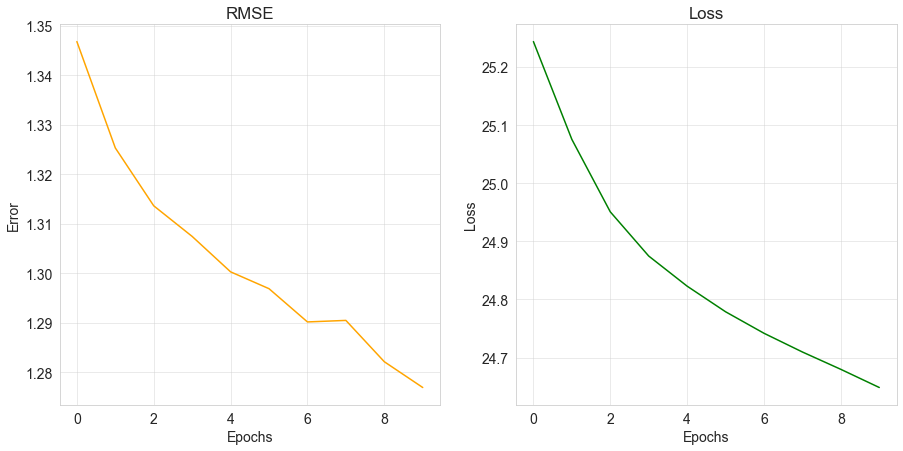

In [46]:
# Visualize model train loss

fig, ax = plt.subplots(
    nrows = 1,
    ncols = 2
)
ax[0].plot(history.history['val_root_mean_squared_error'], color = 'orange')
ax[0].set_title('RMSE')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Error')
ax[0].grid(alpha = 0.5)

ax[1].plot(history.history['loss'], color = 'green')
ax[1].set_title('Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].grid(alpha = 0.5)

# <center> Test data processing

In [47]:
# Creating test data from merged data (merged sales_test with pivot table)
test_data = np.expand_dims(merged_data.iloc[:, 1:], 2)

# Generating predictions
predictions = model.predict(test_data)

   9/6694 [..............................] - ETA: 43s  

2022-07-23 22:34:16.409613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-23 22:34:16.451374: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6694/6694 [==============================] - 40s 6ms/step


In [48]:
# Creating pandas datframe from the sales_test ID's and predictions and saving that
submission = pd.DataFrame({
    'ID':sales_test['ID'],
    'item_cnt_month':predictions.ravel()
})
submission.to_csv('./submission.csv',index = False)